In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
import patsy

In [198]:
filelst = ["YakkertechData/04_05_2022 San Diego@UC San Diego.csv", "YakkertechData/04_08_2022 6_06_03 PM-UC Irvine@UC San Diego.csv",
          "YakkertechData/04_19_2022 5_42_43 PM-San Diego State@UC San Diego.csv", "YakkertechData/04_26_2022 12_41_15 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/04_29_2022 6_13_28 PM-UC Riverside@UC San Diego Friday.csv", "YakkertechData/04_30_2022 1_51_31 PM-UC Riverside@UC San Diego Saturday.csv",
          "YakkertechData/05_01_2022 12_46_25 PM-UC Riverside@UC San Diego Sunday.csv", "YakkertechData/05_06_2022 6_12_16 PM-Cal State Fullerton@UC San Diego Friday.csv",
          "YakkertechData/05_07_2022 1_38_58 PM-Cal State Fullerton@UC San Diego Saturday.csv", "YakkertechData/05_08_2022 12_51_13 PM-Cal State Fullerton@UC San Diego Sunday.csv",
          "YakkertechData/05_21_2022 1_49_44 PM-Hawaii@UC San Diego Saturday.csv", "YakkertechData/05_20_2022 6_28_33 PM-Hawaii@UC San Diego Friday.csv",
          "YakkertechData/05_22_2022 12_54_59 PM-Hawaii@UC San Diego Sunday.csv", "YakkertechData/02_24_2023 10_28_53 AM-Nevada Las Vegas@UC San Diego.csv",
          "YakkertechData/02_26_2023 4_51_20 PM-Washington State@UC San Diego.csv", "YakkertechData/02_27_2023 11_55_47 AM-North Dakota State@UC San Diego.csv",
          "YakkertechData/02_27_2023 3_30_49 PM-North Dakota State@UC San Diego.csv", "YakkertechData/02_27_2023 6_13_41 PM-North Dakota State@UC San Diego.csv",
          "YakkertechData/01_20_2023 1_01_28 PM-UC San Diego@UC San Diego.csv", "YakkertechData/01_20_2023 1_41_11 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/01_20_2023 2_57_34 PM-UC San Diego@UC San Diego.csv", "YakkertechData/01_20_2023 4_16_25 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/01_21_2023 1_57_56 PM-UC San Diego@UC San Diego.csv", "YakkertechData/01_21_2023 3_46_26 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/01_21_2023 4_00_15 PM-UC San Diego@UC San Diego.csv", "YakkertechData/01_27_2023 2_30_58 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/01_28_2023 8_04_35 AM-UC San Diego@UC San Diego.csv", "YakkertechData/01_28_2023 10_10_41 AM-UC San Diego@UC San Diego.csv",
          "YakkertechData/02_03_2023 2_54_37 PM-UC San Diego@UC San Diego.csv", "YakkertechData/02_04_2023 12_05_04 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/02_05_2023 1_11_57 PM-UC San Diego@UC San Diego.csv", "YakkertechData/02_10_2023 2_30_17 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/02_11_2023 11_59_11 AM-UC San Diego@UC San Diego.csv", "YakkertechData/02_12_2023 9_04_22 AM-UC San Diego@UC San Diego.csv",
          "YakkertechData/02_22_2023 5_24_27 PM-UC San Diego@UC San Diego.csv", "YakkertechData/03_01_2023 2_30_03 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/03_03_2023 5_23_28 PM-Santa Clara@UC San Diego.csv", "YakkertechData/03_03_2023 6_09_00 PM-Santa Clara@UC San Diego.csv", 
          "YakkertechData/03_03_2023 7_03_37 PM-Santa Clara@UC San Diego.csv", "YakkertechData/03_03_2023 7_45_02 PM-Santa Clara@UC San Diego.csv",
          "YakkertechData/03_04_2023 1_56_14 PM-Santa Clara@UC San Diego.csv", "YakkertechData/03_05_2023 12_03_19 PM-Santa Clara@UC San Diego.csv",
          "YakkertechData/03_08_2023 3_17_59 PM-UC San Diego@UC San Diego.csv", "YakkertechData/03_10_2023 11_45_40 AM-Northern Colorado@UC San Diego.csv",
          "YakkertechData/03_12_2023 3_06_31 PM-Northern Colorado@UC San Diego.csv", "YakkertechData/03_12_2023 5_45_33 PM-Northern Colorado@UC San Diego.csv",
          "YakkertechData/03_14_2023 3_45_18 PM-UC Riverside@UC San Diego.csv", "YakkertechData/03_14_2023 6_14_42 PM-UC Riverside@UC San Diego.csv",
          "YakkertechData/03_14_2023 6_16_27 PM-UC Riverside@UC San Diego.csv", "YakkertechData/03_17_2023 5_47_48 PM-Long Beach State@UC San Diego.csv",
          "YakkertechData/03_18_2023 1_55_45 PM-Long Beach State@UC San Diego.csv", "YakkertechData/03_19_2023 12_59_21 PM-Long Beach State@UC San Diego.csv",
          "YakkertechData/10_07_2022 1_58_34 PM-UC San Diego@UC San Diego.csv", "YakkertechData/10_07_2022 2_50_36 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/10_14_2022 1_53_25 PM-UC San Diego@UC San Diego.csv", "YakkertechData/10_14_2022 2_23_41 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/10_14_2022 2_27_36 PM-UC San Diego@UC San Diego.csv", "YakkertechData/10_21_2022 1_46_05 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/10_22_2022 9_48_52 AM-UC San Diego@UC San Diego.csv", "YakkertechData/10_28_2022 1_46_02 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/10_29_2022 1_03_58 PM-Cal State Northridge@UC San Diego.csv", "YakkertechData/10_29_2022 3_55_43 PM-Cal State Northridge@UC San Diego.csv",
          "YakkertechData/10_29_2022 12_56_52 PM-Cal State Northridge@UC San Diego.csv", "YakkertechData/11_04_2022 1_34_57 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/11_11_2022 9_59_46 AM-UC San Diego@UC San Diego.csv", "YakkertechData/11_11_2022 11_21_26 AM-UC San Diego@UC San Diego.csv",
          "YakkertechData/11_12_2022 10_00_45 AM-UC San Diego@UC San Diego.csv", "YakkertechData/11_16_2022 1_39_13 PM-UC San Diego@UC San Diego.csv",
          "YakkertechData/11_16_2022 9_02_36 AM-UC San Diego@UC San Diego.csv", "YakkertechData/03_28_2023 5_39_31 PM-San Diego State@UC San Diego.csv",
          "YakkertechData/03_25_2023 1_44_09 PM-Cal State Bakersfield@UC San Diego.csv", "YakkertechData/03_26_2023 12_50_33 PM-Cal State Bakersfield@UC San Diego.csv",
          "YakkertechData/03_24_2023 5_57_04 PM-Cal State Bakersfield@UC San Diego.csv"]

dflst = []
for file in filelst:
    dflst.append(pd.read_csv(file))
allgamedata = pd.concat(dflst)
allgamedata

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,yt_HitSpinConfidence,yt_EffectiveBattingSpeed,yt_ReleaseAccuracy,yt_ZoneAccuracy,yt_SeamLat,yt_SeamLong,yt_ReleaseDistance,Catcher,CatcherId,CatcherTeam
0,1,4/5/2022,6:03:16 PM,1,1,Cole Dale,dale-co42,Right,Uc san diego,Rj Teijeiro,...,NaN,NaN,high,high,27.193961,-26.241644,54.443445,NaN,NaN,NaN
1,2,4/5/2022,6:03:39 PM,1,2,Cole Dale,dale-co42,Right,Uc san diego,Rj Teijeiro,...,NaN,NaN,high,high,46.610423,-72.412489,54.663567,NaN,NaN,NaN
2,3,4/5/2022,6:03:58 PM,1,3,Cole Dale,dale-co42,Right,Uc san diego,Rj Teijeiro,...,NaN,NaN,high,high,20.388702,-23.319167,54.895788,NaN,NaN,NaN
3,4,4/5/2022,6:04:16 PM,1,4,Cole Dale,dale-co42,Right,Uc san diego,Rj Teijeiro,...,NaN,NaN,high,high,48.325344,-47.844249,55.087418,NaN,NaN,NaN
4,5,4/5/2022,6:04:36 PM,1,5,Cole Dale,dale-co42,Right,Uc san diego,Rj Teijeiro,...,NaN,NaN,high,high,64.418061,-12.068055,54.507947,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,267,03/24/2023,8:38:13 PM,3,2,Izaak Martinez,martiiz44,Left,Uc san diego,Jacob Gutierrez,...,NaN,NaN,medium,high,38.296433,-69.385784,54.5,Emiliano Gonzalez,gonzaem47,Uc san diego
267,268,03/24/2023,8:38:28 PM,3,3,Izaak Martinez,martiiz44,Left,Uc san diego,Jacob Gutierrez,...,NaN,NaN,medium,high,39.435182,-59.965064,54.5,Emiliano Gonzalez,gonzaem47,Uc san diego
268,269,03/24/2023,8:38:43 PM,3,4,Izaak Martinez,martiiz44,Left,Uc san diego,Jacob Gutierrez,...,NaN,NaN,high,high,50.526045,-46.42797,54.608739,Emiliano Gonzalez,gonzaem47,Uc san diego
269,270,03/24/2023,8:39:02 PM,3,5,Izaak Martinez,martiiz44,Left,Uc san diego,Jacob Gutierrez,...,NaN,35.594384,high,high,NaN,NaN,53.95139,Emiliano Gonzalez,gonzaem47,Uc san diego


In [199]:
allFB = allgamedata[allgamedata.TaggedPitchType == 'Fastball']
allFB = allFB[['PitcherThrows', 'InducedVertBreak', 'VertBreak', 'yt_Efficiency', 'SpinRate', 'Tilt', 'SpinAxis', 'RelSpeed', 'Extension', 'yt_GyroSpin']]
allFB = allFB.dropna()
allFB

,PitcherThrows,InducedVertBreak,VertBreak,yt_Efficiency,SpinRate,Tilt,SpinAxis,RelSpeed,Extension,yt_GyroSpin
0,Right,12.863587,-23.928309,85.140462,2118.292612,1:30,222.708529,87.556674,6.056555,-1111.064505
1,Right,10.216076,-28.237922,73.251053,1880.562054,1:30,227.984152,85.840794,5.836433,-1280.203346
5,Right,13.020306,-24.000513,76.126316,1989.322103,1:00,209.08794,86.513904,6.103034,-1289.962104
9,Right,13.074782,-22.276491,87.319394,2082.261642,1:15,219.489803,88.826168,6.027481,-1014.837883
15,Right,13.759999,-24.746258,65.297622,2274.229003,12:45,204.809585,84.749202,5.95497,-1722.451947
...,...,...,...,...,...,...,...,...,...,...
251,Right,12.857983,-24.572628,95.118559,1854.976713,1:15,219.327496,87.022287,6.362524,-572.481909
253,Right,12.796418,-22.750449,94.908899,1874.33483,1:15,217.488131,88.404423,6.443338,-590.430603
266,Left,17.6818,-18.713454,93.683361,2293.586627,11:30,164.766402,87.514594,6.0,802.240018
267,Left,17.696091,-17.635634,95.576195,2365.35352,11:15,160.777816,88.870441,6.0,695.748096


Convert Tilt into a numerical value by assigning it a number I call "tiltpoints", which represents the tilt in "minutes" instead of the "hour:minute" clock format the tilt is collected in. The tilt_from_12 function will return the magnitude of the tilt away from 12:00, or straight over the top. Lower numbers will represent tilts higher up on the clock and bigger numbers will represent tilts lower on the clock. Tilts lower than 3 or 9 will be discarded as null, as those were likely misreads, and any pitch marked with lower than 50% efficiency is taken out due to its likelihood the pitch was a higher tilt slider mistagged as a fastball

In [200]:
def tilt_from_12(tilt):
    colonpos = tilt.find(':')
    hour = tilt[:colonpos]
    minute = tilt[colonpos+1:]
    if hour == '9':
        tiltpts = 180 - int(minute)
    elif hour == '10':
        tiltpts = 120 - int(minute)
    elif hour == '11':
        tiltpts = 60 - int(minute)
    elif hour == '12':
        tiltpts = int(minute)
    elif hour == '1':
        tiltpts = 60 + int(minute)
    elif hour == '2':
        tiltpts = 120 + int(minute)
    else:
        tiltpts = np.nan
    return tiltpts
tiltc = allFB.Tilt.apply(tilt_from_12)
allFBclean = allFB.assign(Tilt = tiltc)
allFBclean = allFBclean[allFBclean.yt_Efficiency >= 50]
allFBclean

,PitcherThrows,InducedVertBreak,VertBreak,yt_Efficiency,SpinRate,Tilt,SpinAxis,RelSpeed,Extension,yt_GyroSpin
0,Right,12.863587,-23.928309,85.140462,2118.292612,90.0,222.708529,87.556674,6.056555,-1111.064505
1,Right,10.216076,-28.237922,73.251053,1880.562054,90.0,227.984152,85.840794,5.836433,-1280.203346
5,Right,13.020306,-24.000513,76.126316,1989.322103,60.0,209.08794,86.513904,6.103034,-1289.962104
9,Right,13.074782,-22.276491,87.319394,2082.261642,75.0,219.489803,88.826168,6.027481,-1014.837883
15,Right,13.759999,-24.746258,65.297622,2274.229003,45.0,204.809585,84.749202,5.95497,-1722.451947
...,...,...,...,...,...,...,...,...,...,...
251,Right,12.857983,-24.572628,95.118559,1854.976713,75.0,219.327496,87.022287,6.362524,-572.481909
253,Right,12.796418,-22.750449,94.908899,1874.33483,75.0,217.488131,88.404423,6.443338,-590.430603
266,Left,17.6818,-18.713454,93.683361,2293.586627,30.0,164.766402,87.514594,6.0,802.240018
267,Left,17.696091,-17.635634,95.576195,2365.35352,45.0,160.777816,88.870441,6.0,695.748096


In [201]:
allFBclean.rename(columns = {'InducedVertBreak':'IVB', 'VertBreak':'VB', 'yt_Efficiency':'Efficiency', 
                             'SpinRate':'SpinRate', 'Tilt':'Tilt', 'SpinAxis':'SpinAxis', 
                             'RelSpeed': 'Velocity', 'Extension': 'Extension', 'yt_GyroSpin': 'GyroSpin'}, 
                  inplace = True)
allFBclean

,PitcherThrows,IVB,VB,Efficiency,SpinRate,Tilt,SpinAxis,Velocity,Extension,GyroSpin
0,Right,12.863587,-23.928309,85.140462,2118.292612,90.0,222.708529,87.556674,6.056555,-1111.064505
1,Right,10.216076,-28.237922,73.251053,1880.562054,90.0,227.984152,85.840794,5.836433,-1280.203346
5,Right,13.020306,-24.000513,76.126316,1989.322103,60.0,209.08794,86.513904,6.103034,-1289.962104
9,Right,13.074782,-22.276491,87.319394,2082.261642,75.0,219.489803,88.826168,6.027481,-1014.837883
15,Right,13.759999,-24.746258,65.297622,2274.229003,45.0,204.809585,84.749202,5.95497,-1722.451947
...,...,...,...,...,...,...,...,...,...,...
251,Right,12.857983,-24.572628,95.118559,1854.976713,75.0,219.327496,87.022287,6.362524,-572.481909
253,Right,12.796418,-22.750449,94.908899,1874.33483,75.0,217.488131,88.404423,6.443338,-590.430603
266,Left,17.6818,-18.713454,93.683361,2293.586627,30.0,164.766402,87.514594,6.0,802.240018
267,Left,17.696091,-17.635634,95.576195,2365.35352,45.0,160.777816,88.870441,6.0,695.748096


Very messy data - lots of observations that don't make sense
Solution: Choose ranges for each metric to analyze - wide enough to include all good data but narrow enough to discard outliers
- IVB: 7"-22"
- Efficiency: 50%-100%
- Spin Rate: 1000rpm-3000rpm
- Tilt: 9:00-12:00, 12:00-3:00
- Velo: 77-100
- Extension: 5'-8'

In [202]:
allFBclean = allFBclean[((allFBclean.IVB > 7) & (allFBclean.IVB < 22))
                       & ((allFBclean.get('SpinRate') > 1000) & (allFBclean.get('SpinRate') < 3000))
                       & ((allFBclean.Velocity > 77) & (allFBclean.Velocity < 100))
                       & ((allFBclean.Extension > 5) & (allFBclean.Extension < 8))]
allFBclean

,PitcherThrows,IVB,VB,Efficiency,SpinRate,Tilt,SpinAxis,Velocity,Extension,GyroSpin
0,Right,12.863587,-23.928309,85.140462,2118.292612,90.0,222.708529,87.556674,6.056555,-1111.064505
1,Right,10.216076,-28.237922,73.251053,1880.562054,90.0,227.984152,85.840794,5.836433,-1280.203346
5,Right,13.020306,-24.000513,76.126316,1989.322103,60.0,209.08794,86.513904,6.103034,-1289.962104
9,Right,13.074782,-22.276491,87.319394,2082.261642,75.0,219.489803,88.826168,6.027481,-1014.837883
15,Right,13.759999,-24.746258,65.297622,2274.229003,45.0,204.809585,84.749202,5.95497,-1722.451947
...,...,...,...,...,...,...,...,...,...,...
251,Right,12.857983,-24.572628,95.118559,1854.976713,75.0,219.327496,87.022287,6.362524,-572.481909
253,Right,12.796418,-22.750449,94.908899,1874.33483,75.0,217.488131,88.404423,6.443338,-590.430603
266,Left,17.6818,-18.713454,93.683361,2293.586627,30.0,164.766402,87.514594,6.0,802.240018
267,Left,17.696091,-17.635634,95.576195,2365.35352,45.0,160.777816,88.870441,6.0,695.748096


Identify relationships between variables and IVB using scatterplots

<AxesSubplot:xlabel='Efficiency', ylabel='IVB'>

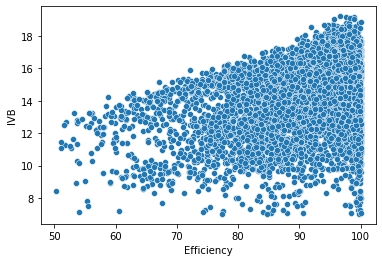

In [203]:
sns.scatterplot(x = 'Efficiency', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='SpinRate', ylabel='IVB'>

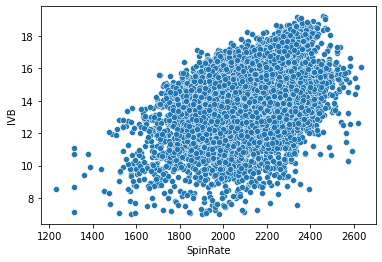

In [204]:
sns.scatterplot(x = 'SpinRate', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='Tilt', ylabel='IVB'>

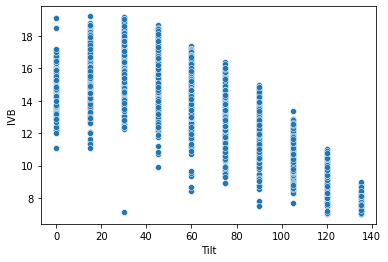

In [205]:
sns.scatterplot(x = 'Tilt', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='SpinAxis', ylabel='IVB'>

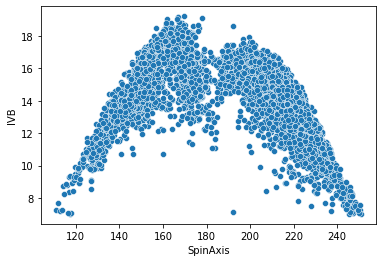

In [206]:
sns.scatterplot(x = 'SpinAxis', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='Velocity', ylabel='IVB'>

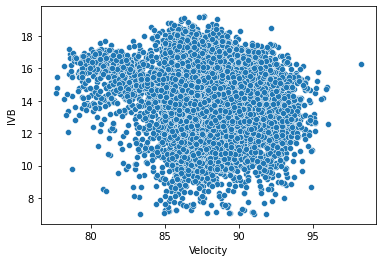

In [207]:
sns.scatterplot(x = 'Velocity', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='Extension', ylabel='IVB'>

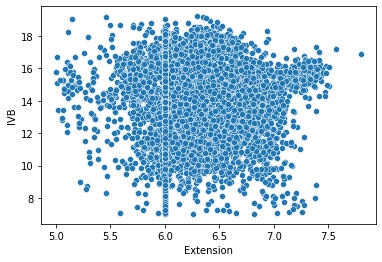

In [208]:
sns.scatterplot(x = 'Extension', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='GyroSpin', ylabel='IVB'>

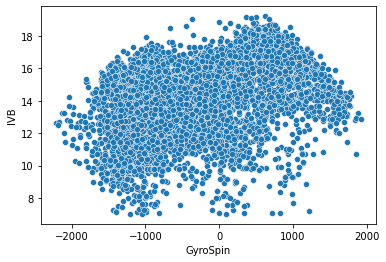

In [209]:
sns.scatterplot(x = 'GyroSpin', y = 'IVB', data = allFBclean)

Features chosen for regression analysis:
- Spin Rate
- Spin Efficiency
- Tilt
- Velocity
- Extension
- Gyro Spin

Spin Axis will not be used as it is pretty much the same metric as Tilt. Velocity and Extension show no correlation when compared to IVB in the single variable scatterplots, but they will be left in to see if there is a correlation in the multi-dimensional regression analysis

In [210]:
allFBcleani = allFBclean.assign(index = list(range(allFBclean.shape[0]))).set_index('index')
training = allFBcleani.sample(int(allFBclean.shape[0] * .9), random_state = 10)
training

,PitcherThrows,IVB,VB,Efficiency,SpinRate,Tilt,SpinAxis,Velocity,Extension,GyroSpin
index,,,,,,,,,,
1961,Right,13.028166,-18.510686,99.982293,2248.161669,90.0,223.812933,92.938132,6.69172,-42.30575
46,Right,10.827906,-26.849916,89.164203,1796.170983,90.0,228.501614,85.879608,6.070382,-813.200401
3155,Right,14.498372,-20.216462,99.781058,2289.624749,75.0,220.006559,91.149373,6.417128,-151.42804
1906,Left,10.057835,-25.259029,99.997065,1687.960135,105.0,128.398392,87.14486,6.1464,12.931544
1717,Left,14.721128,-19.473028,99.75268,1963.629735,60.0,151.403989,89.964291,6.168331,-138.017815
...,...,...,...,...,...,...,...,...,...,...
5286,Right,9.535561,-22.737892,70.081541,2134.455307,105.0,229.808997,92.215233,6.361716,-1522.598046
3326,Left,17.031771,-19.213611,94.846825,2264.253439,45.0,159.592323,86.995062,6.412438,717.478905
1524,Right,12.797943,-21.848251,94.794518,1971.726895,75.0,219.260004,89.351616,6.158358,-627.864027


In [211]:
training_i = list(training.index)
test_i = []
for i in range(allFBclean.shape[0]):
    if i not in training_i:
        test_i.append(i)
test = allFBcleani.loc[test_i]
test

,PitcherThrows,IVB,VB,Efficiency,SpinRate,Tilt,SpinAxis,Velocity,Extension,GyroSpin
index,,,,,,,,,,
0,Right,12.863587,-23.928309,85.140462,2118.292612,90.0,222.708529,87.556674,6.056555,-1111.064505
26,Right,10.748518,-27.030912,86.115376,1832.993354,105.0,229.022278,86.802243,6.239205,-931.792215
44,Left,13.795867,-23.121888,82.879688,1772.171263,30.0,162.606921,87.000655,5.903944,991.617697
55,Right,10.238828,-27.325535,84.511615,1774.68442,105.0,229.556023,86.67965,6.240494,-948.715649
58,Right,10.319147,-26.307394,83.674903,1763.985383,90.0,227.685519,87.328025,5.910491,-965.934709
...,...,...,...,...,...,...,...,...,...,...
6479,Right,12.473132,-22.739483,97.352056,1770.877059,75.0,218.087377,88.588503,6.190524,-404.821536
6484,Right,11.823069,-23.827829,99.736505,1831.093089,90.0,225.312786,87.94263,6.499696,-132.839003
6486,Right,11.773469,-19.440042,99.85273,2305.812566,105.0,230.201348,93.899457,6.652068,125.093713


Helper functions for creating a design matrix and solving linear regression using the normal equation

Code from DSC40A class taught by Truong Son Hy, Madhi Soleymani, and TAs

In [212]:
def solve_normal_equations(X, y):
    '''Returns the optimal parameter vector, w*, given a design matrix X and observation vector y.'''
    return np.linalg.solve(X.T @ X, X.T @ y)

def create_design_matrix(df, columns, intercept=True):
    '''Creates a design matrix by taking the specified columns from the DataFrame df.
       Adds a column of all 1s as the first column if intercept is True, which is the default.
       The argument columns should be a list.
    '''
    df = df.copy()
    df['1'] = 1
    if intercept:
        return df[['1'] + columns].values
    else:
        return df[columns].values

In [213]:
design_matrix = create_design_matrix(training, ['SpinRate', 'Efficiency', 'Tilt', 'Velocity', 'Extension', 'GyroSpin'])
observation_vector = np.array(training['IVB'])
weights = solve_normal_equations(design_matrix, observation_vector)
weights

UFuncTypeError: Cannot cast ufunc 'solve1' input 0 from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [214]:
ivb, predictors = patsy.dmatrices('IVB ~ Efficiency + SpinRate + Tilt + Velocity + Extension + GyroSpin', training)
mod = sm.OLS(ivb, predictors)
res = mod.fit()
res.summary()

TypeError: Axis must be specified when shapes of a and weights differ.